In [39]:
import os
import pandas as pd
import nltk
from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Concatenate, Dropout, LSTM, GRU
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [21]:
from google.colab import files

# Загружаем файл
uploaded = files.upload()

Saving main_df.csv to main_df (1).csv


In [26]:
df = pd.read_csv("main_df.csv")
df.head()

,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,"['достоинство', 'всё', 'устроить', 'нормальный...",2024-10-09,5,54,0,0,0
1,1,"['шикарный', 'начитаться', 'отзыв', 'рискнуть'...",2024-10-09,5,195,0,0,0
2,2,"['дочка', 'понравиться']",2024-10-09,5,17,0,0,0
3,3,"['пока', 'не', 'одевать', 'то', 'что', 'хотеть']",2024-10-09,5,33,0,0,0
4,4,"['отличный', 'куртка']",2024-10-09,5,15,0,0,0


In [27]:
import ast

df["User review"] = [ast.literal_eval(x) for x in df["User review"]]

df.head()

,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,"[достоинство, всё, устроить, нормальный, демис...",2024-10-09,5,54,0,0,0
1,1,"[шикарный, начитаться, отзыв, рискнуть, что, б...",2024-10-09,5,195,0,0,0
2,2,"[дочка, понравиться]",2024-10-09,5,17,0,0,0
3,3,"[пока, не, одевать, то, что, хотеть]",2024-10-09,5,33,0,0,0
4,4,"[отличный, куртка]",2024-10-09,5,15,0,0,0


In [28]:
df = df.drop(columns=["Unnamed: 0"])
df.head()

,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,"[достоинство, всё, устроить, нормальный, демис...",2024-10-09,5,54,0,0,0
1,"[шикарный, начитаться, отзыв, рискнуть, что, б...",2024-10-09,5,195,0,0,0
2,"[дочка, понравиться]",2024-10-09,5,17,0,0,0
3,"[пока, не, одевать, то, что, хотеть]",2024-10-09,5,33,0,0,0
4,"[отличный, куртка]",2024-10-09,5,15,0,0,0


In [30]:
from gensim.models import Word2Vec
import numpy as np

reviews = df['User review'].values
w2v_model = Word2Vec(reviews, vector_size=100, window=5, min_count=5)

def average_vector(words):
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

w2v_tokens = np.array([average_vector(review) for review in reviews])

w2v_tokens = list(w2v_tokens)

df_with_w2v = df.copy()

df_with_w2v['User review'] = w2v_tokens

df_with_w2v.head()

,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,"[-0.08849775046110153, 0.20628713071346283, 0....",2024-10-09,5,54,0,0,0
1,"[-0.09326332062482834, 0.23170405626296997, 0....",2024-10-09,5,195,0,0,0
2,"[-0.047767870128154755, 0.11743941158056259, 0...",2024-10-09,5,17,0,0,0
3,"[-0.13156969845294952, 0.3168233633041382, 0.0...",2024-10-09,5,33,0,0,0
4,"[-0.07733380794525146, 0.2077724039554596, 0.0...",2024-10-09,5,15,0,0,0


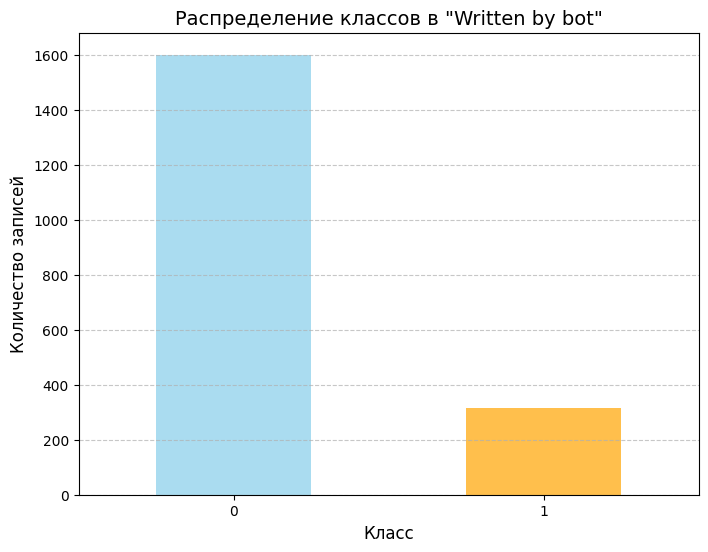

In [34]:
import matplotlib.pyplot as plt
df = df_with_w2v.copy()
class_counts = df['Written by bot'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7)
plt.title('Распределение классов в "Written by bot"', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [35]:
df['Review date'] = pd.to_datetime(df['Review date'], errors='coerce')
df['year'] = df['Review date'].dt.year
df['month'] = df['Review date'].dt.month
df['day'] = df['Review date'].dt.day
target = df['Written by bot']
df = df.drop(columns=["Review date"])
df.head()

,User review,Star review,Text length,Has media,Has answer,Written by bot,year,month,day
0,"[-0.08849775046110153, 0.20628713071346283, 0....",5,54,0,0,0,2024,10,9
1,"[-0.09326332062482834, 0.23170405626296997, 0....",5,195,0,0,0,2024,10,9
2,"[-0.047767870128154755, 0.11743941158056259, 0...",5,17,0,0,0,2024,10,9
3,"[-0.13156969845294952, 0.3168233633041382, 0.0...",5,33,0,0,0,2024,10,9
4,"[-0.07733380794525146, 0.2077724039554596, 0.0...",5,15,0,0,0,2024,10,9


Исходное распределение классов: Counter({0: 1602, 1: 314})


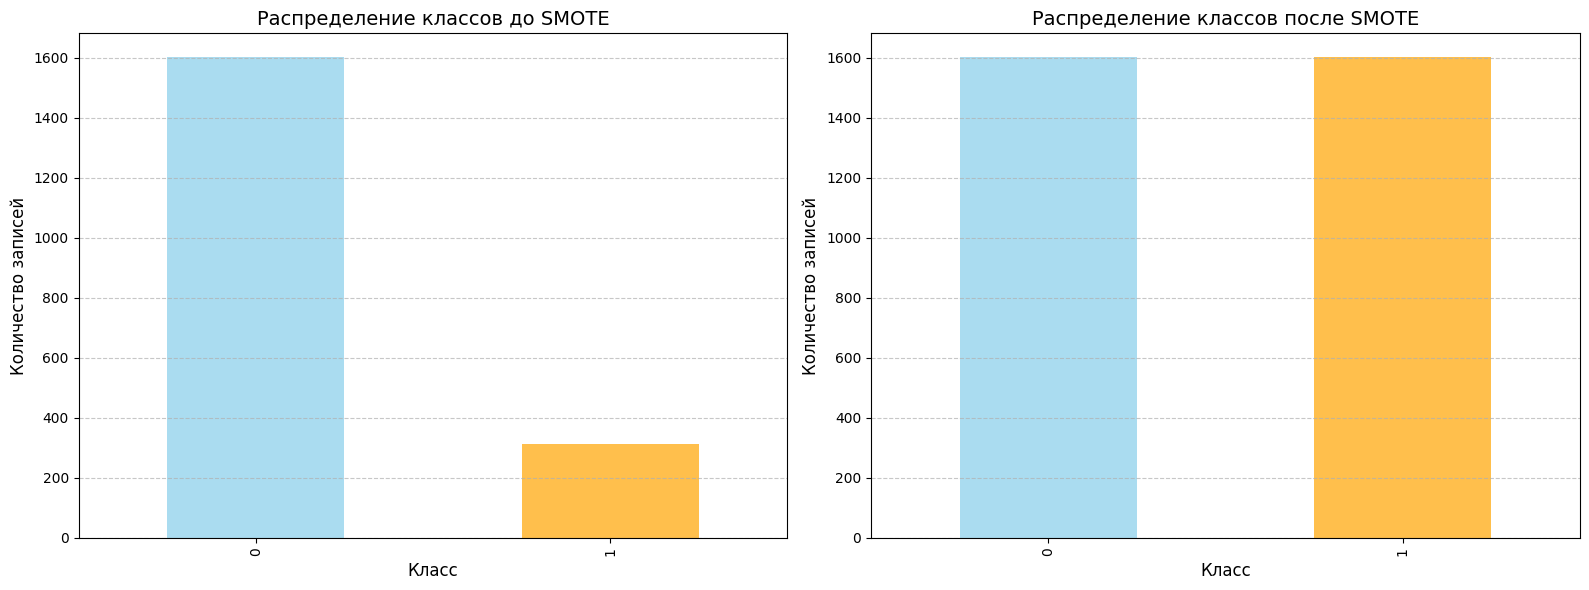

In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter

df["User review"] = np.stack(df["User review"].values)
y = df['Written by bot']

X = df.drop(columns=['Written by bot']).values

print("Исходное распределение классов:", Counter(y))

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_counts_before = y.value_counts()
class_counts_before.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[0])
axes[0].set_title('Распределение классов до SMOTE', fontsize=14)
axes[0].set_xlabel('Класс', fontsize=12)
axes[0].set_ylabel('Количество записей', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

class_counts_after = pd.Series(y_smote).value_counts()
class_counts_after.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[1])
axes[1].set_title('Распределение классов после SMOTE', fontsize=14)
axes[1].set_xlabel('Класс', fontsize=12)
axes[1].set_ylabel('Количество записей', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [44]:
X_smote_df = pd.DataFrame(X_smote, columns=df.drop(columns=['Written by bot']).columns)
X_smote_text = X_smote_df['User review']
X_smote_numeric = X_smote_df.drop(columns=['User review'])
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_smote_text, X_smote_numeric, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Проверяем размеры выборок
print(f"Размеры текстовых данных:")
print(f"X_train_text: {X_train_text.shape}, X_test_text: {X_test_text.shape}")
print(f"Размеры числовых данных:")
print(f"X_train_num: {X_train_num.shape}, X_test_num: {X_test_num.shape}")
print(f"Размеры меток:")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Размеры текстовых данных:
X_train_text: (2563,), X_test_text: (641,)
Размеры числовых данных:
X_train_num: (2563, 7), X_test_num: (641, 7)
Размеры меток:
y_train: (2563,), y_test: (641,)


GlobalPooling2D

In [45]:
maxlen = 1000
text_input = Input(shape=(maxlen,), name='text_input')
x_text = Embedding(1001, 64)(text_input)
x_text = GlobalAveragePooling1D()(x_text)
x_text = Dense(64, activation='relu')(x_text)

num_input = Input(shape=(7,), name='num_input')
x_num = Dense(32, activation='relu')(num_input)

combined = Concatenate()([x_text, x_num])

In [46]:
# основное тело нейросети
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.1)(x)

output = Dense(2, activation='softmax')(x)

model = Model(inputs=[text_input, num_input], outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32
)

test_loss, test_accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 1000)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1000, 64)       │         64,064 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ embedding_1[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 7)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          4,160 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │            256 │ num_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 96)             │              0 │ dense_6[0][0],         │
│ (Concatenate)             │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          6,208 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │          8,320 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │          8,256 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 2)              │            130 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 91,394 (357.01 KB)

 Trainable params: 91,394 (357.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4857 - loss: 48.3471 - val_accuracy: 0.4992 - val_loss: 3.5922
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5162 - loss: 4.8431 - val_accuracy: 0.4992 - val_loss: 1.9288
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4848 - loss: 2.6581 - val_accuracy: 0.4992 - val_loss: 1.7884
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4925 - loss: 1.9574 - val_accuracy: 0.4852 - val_loss: 1.7009
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5134 - loss: 1.7393 - val_accuracy: 0.5133 - val_loss: 1.6741
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5148 - loss: 1.6962 - val_accuracy: 0.5008 - val_loss: 1.6526
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5063 - loss: 1.6580 - val_accuracy: 0.4992 - val_loss: 1.6305
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5251 - loss: 1.6334 - val_accuracy: 0.4992 - val_loss

LSTM

In [47]:
text_input = Input(shape=(maxlen,), name='text_input')
x_text = Embedding(1001, 64)(text_input)
x_text = GlobalAveragePooling1D()(x_text)
x_text = Dense(64, activation='relu')(x_text)

num_input = Input(shape=(7,), name='num_input')
x_num = Dense(32, activation='relu')(num_input)

combined = Concatenate()([x_text, x_num])

In [48]:
# основное тело нейросети
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.1)(x)

output = Dense(2, activation='softmax')(x)

model = Model(inputs=[text_input, num_input], outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32
)

test_loss, test_accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 1000)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1000, 64)       │         64,064 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ embedding_2[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 7)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 64)             │          4,160 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 32)             │            256 │ num_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 96)             │              0 │ dense_12[0][0],        │
│ (Concatenate)             │                        │                │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 64)             │          6,208 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64)             │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 128)            │          8,320 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 64)             │          8,256 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 2)              │            130 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 91,394 (357.01 KB)

 Trainable params: 91,394 (357.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5119 - loss: 12.9595 - val_accuracy: 0.5429 - val_loss: 2.0680
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5126 - loss: 2.9024 - val_accuracy: 0.5039 - val_loss: 1.7470
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5056 - loss: 1.8544 - val_accuracy: 0.3354 - val_loss: 1.6493
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4955 - loss: 1.6795 - val_accuracy: 0.4992 - val_loss: 1.5982
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5171 - loss: 1.6019 - val_accuracy: 0.5008 - val_loss: 1.5552
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5062 - loss: 1.5609 - val_accuracy: 0.5008 - val_loss: 1.5160
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4969 - loss: 1.5237 - val_accuracy: 0.4992 - val_loss: 1.4803
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5066 - loss: 1.4773 - val_accuracy: 0.4992 - val_los

GRU

In [49]:
text_input = Input(shape=(maxlen,), name='text_input')
x_text = Embedding(1001, 64)(text_input)
x_text = GRU(64, return_sequences=False)(x_text)
x_text = Dense(64, activation='relu')(x_text)

num_input = Input(shape=(7,), name='num_input')
x_num = Dense(32, activation='relu')(num_input)

combined = Concatenate()([x_text, x_num])

In [50]:
# основное тело нейросети
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.1)(x)

output = Dense(2, activation='softmax')(x)

model = Model(inputs=[text_input, num_input], outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32
)

test_loss, test_accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 1000)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1000, 64)       │         64,064 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 64)             │         24,960 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 7)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 64)             │          4,160 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 32)             │            256 │ num_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 96)             │              0 │ dense_18[0][0],        │
│ (Concatenate)             │                        │                │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 64)             │          6,208 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64)             │              0 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 128)            │          8,320 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128)            │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 64)             │          8,256 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64)             │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 2)              │            130 │ dropout_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 116,354 (454.51 KB)

 Trainable params: 116,354 (454.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4922 - loss: 22.1658 - val_accuracy: 0.4587 - val_loss: 2.3115
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5033 - loss: 3.1978 - val_accuracy: 0.5008 - val_loss: 1.7151
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5009 - loss: 1.8434 - val_accuracy: 0.5538 - val_loss: 1.6027
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5093 - loss: 1.6357 - val_accuracy: 0.5086 - val_loss: 1.5589
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5026 - loss: 1.5643 - val_accuracy: 0.5523 - val_loss: 1.5205
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5440 - loss: 1.5187 - val_accuracy: 0.5367 - val_loss: 1.4854
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5166 - loss: 1.5062 - val_accuracy: 0.5211 - val_loss: 1.4606
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5224 - loss: 1.4554 - val_accuracy: 0.5398 - val_los